In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nozzle import Spectral, Params, Nozzle, Boundary
from scipy.integrate import simpson

# SINE

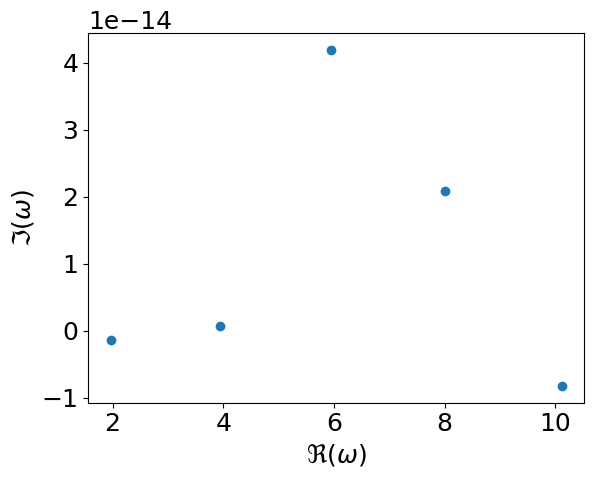

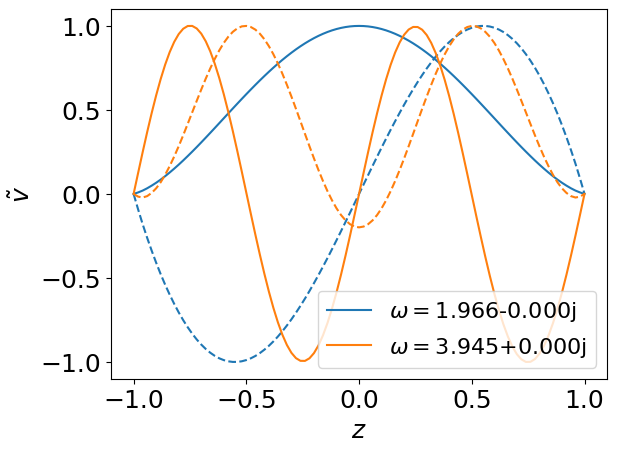

In [6]:
N = 50 # number of sine basis
M = 101 # number of points
Mm = 1.5
constant_v = True
accelerating = False
boundary = Boundary.FIXED_FIXED
params = Params(Mm, constant_v, accelerating, boundary)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

L = 2
x0 = -1
u = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))

# A2 = np.eye(N,dtype=complex)
A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(1,N+1):
    for j in range(1,N+1):
        A2[i-1,j-1] = simpson(u(x,i)*u(x,j),x)
        A1[i-1,j-1] = 2j*simpson(u(x,i)*v0*(D1@u(x,j)) + u(x,i)*(D1@v0)*u(x,j),x)
        A0[i-1,j-1] = simpson(
            u(x,i)*(1-v0**2)*(D2@u(x,j)) -
            u(x,i)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j)) - 
            u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
            u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
            x)
        

C, nozzle.omega = nozzle.solve(A0,A1,A2)
nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
for i in range(C.shape[1]):
    for n in range(N):
            nozzle.V[:,i] += C[n,i]*u(x, n)
nozzle.sort_solutions(real_range=[0.1,11], imag_range=[-1,1])
nozzle.sort_solutions(real_range=[0,20], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=2)
nozzle.save_data("SE", N=N)

## Open right end

IndexError: index 4 is out of bounds for axis 1 with size 4

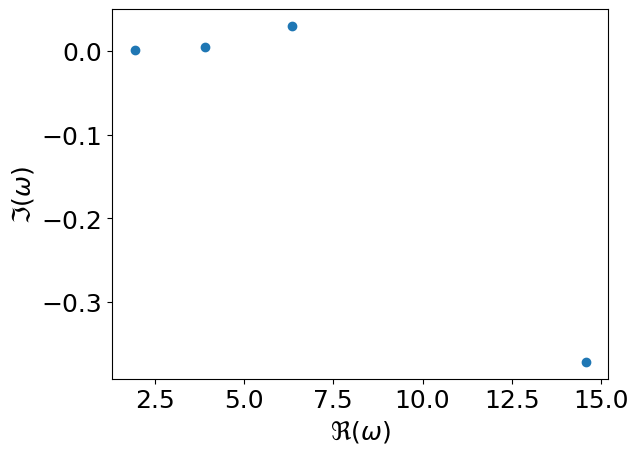

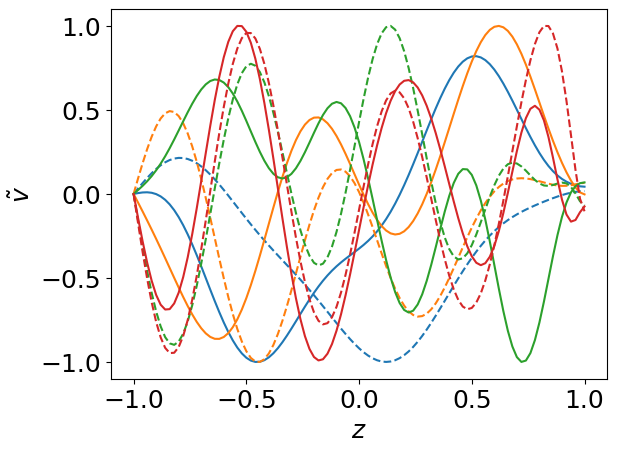

In [22]:
N = 11 # number of sine basis
M = 101 # number of points
Mm = 1.5
constant_v = True
accelerating = False

params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

u = lambda x,n: np.sin((n+1)*np.pi/4*(x+1))
u_p = lambda x,n: (n+1)*np.pi/4*np.cos((n+1)*np.pi/4*(x+1))
u_pp = lambda x,n: -((n+1)*np.pi/4)**2*np.sin((n+1)*np.pi/4*(x+1))

# A2 = np.eye(N,dtype=complex)
A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        A2[i,j] = simpson(u(x,i)*u(x,j),x)
        A1[i,j] = 2j*simpson(u(x,i)*v0*u_p(x,j) + u(x,i)*(D1@v0)*u(x,j),x)
        A0[i,j] = simpson(
            u(x,i)*(1-v0**2)*u_pp(x,j) -
            # -D1@(u(x,i)*(1-v0**2))*u_p(x,j) -
            u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,j) - 
            u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
            u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
            x)

    # open right end condition
    A2[i,j] -= u_p(1,j)/u_p(1,N)*simpson(u(x,i)*u(x,N),x)
    A1[i,j] -= 2j*u_p(1,j)/u_p(1,N)*simpson(u(x,i)*(v0*u_p(x,N)+(D1@v0)*u(x,N)),x)
    A0[i,j] -= u_p(1,j)/u_p(1,N)*simpson(
            u(x,i)*(1-v0**2)*u_pp(x,N) -
            u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,N) - 
            u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,N) -
            u(x,i)*(v0+1/v0)*(D2@v0)*u(x,N),
            x)


C, nozzle.omega = nozzle.polyeig(A0,A1,A2)
nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
for i in range(C.shape[1]):
    for n in range(N+1):
        if (n<N):
            nozzle.V[:,i] += C[n,i]*u(x, n)
        else:
            cN = -np.sum(C[:,i]*u_p(1,np.arange(N)))/u_p(1,N)
            nozzle.V[:,i] += cN*u(x, N)


# nozzle.solve(A0,A1,A2)
nozzle.sort_solutions(real_range=[0,20], imag_range=[-1,1])
nozzle.plot_eigenvalues()
ax = nozzle.plot_eigenfunctions(num_funcs=5)
ax.legend(fontsize="medium")

# nozzle.save_data("SE_Sine", N=N)